In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    print(f"CUDA available. Using device \"{torch.cuda.get_device_name()}\".")
else:
    print(f"CUDA not available.")

CUDA available. Using device "NVIDIA GeForce GTX 1650 with Max-Q Design".


In [193]:
### NUMERICAL SIMULATOR ###
import scipy.integrate
def numerical_schrodinger(psi0, v, ts, length=1, size=100, verbose=False):
#     xs = np.linspace(0,length,size)
#     dx = length/size
    
#     # construct laplacian operator and then Hamiltonian
#     D2 = -2*np.eye(size)
#     for i in range(size-1):
#         D2[i,i+1] = 1
#         D2[i+1,i] = 1
#     H = -0.5*D2/(dx**2) + np.diag(v(xs))
    
#     y0 = psi0(xs)*(1+0j)
    
#     if verbose:
#         energy = y0.transpose()@H@y0/(y0.transpose()@y0)
#         print(f'Energy expectation value is {energy}.')
    
#     sol = scipy.integrate.solve_ivp(lambda t,p: H@p / 1j, t_span=[0,np.max(ts)], y0=y0, t_eval=ts, method="RK23")
#     return sol.t, sol.y

    xs = np.linspace(0,length,size)
    dx = length/size
    
    # construct laplacian operator and then Hamiltonian
    D2 = -2*np.eye(size)
    for i in range(size-1):
        D2[i,i+1] = 1
        D2[i+1,i] = 1
    
    off_diags = np.array([[0,1],[-1,0]])
    
    H = np.kron(off_diags, -0.5*D2/(dx**2) + np.diag(v(xs)))
    
    y0_cmplx = psi0(xs)*(1+0j)
    y0_real = np.concatenate((y0_cmplx.real, y0_cmplx.imag))
    
    sol = scipy.integrate.solve_ivp(lambda t,p: H@p, t_span=[0,np.max(ts)], y0=y0_real, t_eval=ts, method="RK23")
    sol_cmplx = sol.y[:size,:] + 1j*sol.y[size:,:]
    #sol = scipy.integrate.odeint(lambda p,t: H@p, t=ts, y0=y0_real)
    #sol_cmplx = sol[:,:size] + 1j*sol[:,size:]
    
    return ts, sol_cmplx

In [157]:
### MODEL DEFN ###
class SimpleFiniteStepSolver(nn.Module):
    def __init__(self, size=100, length=1):
        super(SimpleFiniteStepSolver, self).__init__()
        self.size = size
        self.length = length

        self.mlp = nn.Sequential(
            nn.Linear(3*size+1, 10*size),
            nn.ReLU(),
            nn.Linear(10*size,2*size)
        ).to(device)

    def forward(self, x):
        outs = self.mlp(x)
        return outs

In [64]:
### TRAINING DATA ###
from tqdm import tqdm
import scipy.interpolate

class SimpleFiniteStepDataset(torch.utils.data.Dataset):
    def __init__(self, size=25, sim_size=100, length=1, nums=500, modes=5, max_time=10, times_per_generate=50):
        self.size = size
        self.sim_size = sim_size
        self.length = length
        self.modes = modes
        self.max_time = max_time
        self.times_per_generate = times_per_generate
        self.nums = nums
        
        self.data = []
        for i in tqdm(range(nums)):
            self._generate_data()
        
    def _cmplx_to_real(self, z):
        assert list(z.shape) == [self.size]
        if not torch.is_tensor(z):
            z = torch.from_numpy(z)
        return torch.cat((z.real, z.imag))

    def _real_to_cmplx(self, x):
        assert list(x.shape) == [self.size*2]
        real = x[0:self.size]
        imag = x[self.size:2*self.size]
        return torch.complex(real, imag)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):    
        return self.data[index]
        
    def _generate_data(self):
        cffs1 = torch.rand(self.modes) + 1j*torch.rand(self.modes)
        wavefn = lambda x: torch.sum(torch.outer(cffs1,torch.ones(len(x)))*torch.sin(torch.outer(torch.arange(0,self.modes), (x if torch.is_tensor(x) else torch.tensor(x))  )*np.pi/self.length), dim=0)
        
        cffs2 = torch.rand(self.modes)
        #potential = lambda x: torch.sum(torch.outer(cffs2,torch.ones(len(xs)))*torch.sin(torch.outer(torch.arange(0,self.modes),xs)*np.pi/self.length), dim=0)
        potential = lambda x: 0*x
        
        xs = torch.linspace(0,self.length,self.size)
        psis = wavefn(xs)
        vs = potential(xs)
        psis_and_vs = torch.cat((self._cmplx_to_real(psis), vs))
        
        ts = np.sort(np.random.rand(self.times_per_generate)*self.length)
        
        # expected wavefn
        num_t, num_y = numerical_schrodinger(wavefn, potential, ts, size=self.sim_size, length=self.length)
        
        # interpolate
        num_y = scipy.interpolate.interp1d(np.linspace(0,self.length,self.sim_size), num_y, axis=0)(np.linspace(0,self.length,self.size))
        
        for i in range(len(num_t)):
            nn_in = torch.cat((torch.tensor([num_t[i]]), psis_and_vs)).type(torch.FloatTensor)
            nn_out = self._cmplx_to_real(num_y[:,i]).type(torch.FloatTensor)
            self.data.append((nn_in, nn_out))

In [105]:
# Generate training data
from tqdm import tqdm

print('Generating data...')
data = SimpleFiniteStepDataset(size=50, sim_size=100, max_time=1, nums=200)
print('Training data generated!')

Generating data...


100%|██████████| 200/200 [10:19<00:00,  3.10s/it]

Training data generated!


In [159]:
# Try to train
from tqdm import tqdm

EPOCHS = 500

model = SimpleFiniteStepSolver(size=50)

train_data_loader = torch.utils.data.DataLoader(data, batch_size=10, shuffle=True)


optm = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for x,y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)
        
        optm.zero_grad()
        output = model(x)
        loss = F.mse_loss(output,y)
        loss.backward()
        optm.step()
        
        epoch_loss+=loss
        
    print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))

100%|██████████| 1000/1000 [00:01<00:00, 538.10it/s]


Epoch 1 Loss : 589.782958984375


100%|██████████| 1000/1000 [00:02<00:00, 357.21it/s]


Epoch 2 Loss : 528.3787841796875


100%|██████████| 1000/1000 [00:02<00:00, 355.46it/s]


Epoch 3 Loss : 511.3597106933594


100%|██████████| 1000/1000 [00:02<00:00, 361.06it/s]


Epoch 4 Loss : 503.90191650390625


100%|██████████| 1000/1000 [00:02<00:00, 375.36it/s]


Epoch 5 Loss : 496.1015625


100%|██████████| 1000/1000 [00:02<00:00, 422.42it/s]


Epoch 6 Loss : 489.5447082519531


100%|██████████| 1000/1000 [00:01<00:00, 598.67it/s]


Epoch 7 Loss : 484.75250244140625


100%|██████████| 1000/1000 [00:01<00:00, 505.88it/s]


Epoch 8 Loss : 479.84234619140625


100%|██████████| 1000/1000 [00:02<00:00, 493.42it/s]


Epoch 9 Loss : 478.5960388183594


100%|██████████| 1000/1000 [00:01<00:00, 511.11it/s]


Epoch 10 Loss : 474.32025146484375


100%|██████████| 1000/1000 [00:01<00:00, 539.50it/s]


Epoch 11 Loss : 471.4218444824219


100%|██████████| 1000/1000 [00:02<00:00, 477.47it/s]


Epoch 12 Loss : 468.49298095703125


100%|██████████| 1000/1000 [00:02<00:00, 493.97it/s]


Epoch 13 Loss : 466.2234191894531


100%|██████████| 1000/1000 [00:02<00:00, 485.69it/s]


Epoch 14 Loss : 463.3972473144531


100%|██████████| 1000/1000 [00:01<00:00, 522.24it/s]


Epoch 15 Loss : 460.69482421875


100%|██████████| 1000/1000 [00:02<00:00, 473.57it/s]


Epoch 16 Loss : 458.6834411621094


100%|██████████| 1000/1000 [00:02<00:00, 434.39it/s]


Epoch 17 Loss : 455.92962646484375


100%|██████████| 1000/1000 [00:02<00:00, 410.77it/s]


Epoch 18 Loss : 454.7186279296875


100%|██████████| 1000/1000 [00:02<00:00, 446.59it/s]


Epoch 19 Loss : 453.2575988769531


100%|██████████| 1000/1000 [00:02<00:00, 414.60it/s]


Epoch 20 Loss : 450.40625


100%|██████████| 1000/1000 [00:02<00:00, 441.95it/s]


Epoch 21 Loss : 449.0199890136719


100%|██████████| 1000/1000 [00:02<00:00, 427.27it/s]


Epoch 22 Loss : 448.0472106933594


100%|██████████| 1000/1000 [00:02<00:00, 418.84it/s]


Epoch 23 Loss : 445.57843017578125


100%|██████████| 1000/1000 [00:02<00:00, 410.55it/s]


Epoch 24 Loss : 445.2386779785156


100%|██████████| 1000/1000 [00:02<00:00, 443.24it/s]


Epoch 25 Loss : 443.4087829589844


100%|██████████| 1000/1000 [00:02<00:00, 432.99it/s]


Epoch 26 Loss : 443.5091552734375


100%|██████████| 1000/1000 [00:02<00:00, 449.85it/s]


Epoch 27 Loss : 441.4053039550781


100%|██████████| 1000/1000 [00:02<00:00, 421.57it/s]


Epoch 28 Loss : 441.24432373046875


100%|██████████| 1000/1000 [00:02<00:00, 409.39it/s]


Epoch 29 Loss : 438.6015930175781


100%|██████████| 1000/1000 [00:02<00:00, 428.41it/s]


Epoch 30 Loss : 437.2536926269531


100%|██████████| 1000/1000 [00:02<00:00, 440.64it/s]


Epoch 31 Loss : 436.4804382324219


100%|██████████| 1000/1000 [00:02<00:00, 446.92it/s]


Epoch 32 Loss : 434.72650146484375


100%|██████████| 1000/1000 [00:02<00:00, 425.38it/s]


Epoch 33 Loss : 435.0957946777344


100%|██████████| 1000/1000 [00:02<00:00, 431.89it/s]


Epoch 34 Loss : 433.8843994140625


100%|██████████| 1000/1000 [00:02<00:00, 396.69it/s]


Epoch 35 Loss : 433.45025634765625


100%|██████████| 1000/1000 [00:02<00:00, 458.23it/s]


Epoch 36 Loss : 433.7488708496094


100%|██████████| 1000/1000 [00:02<00:00, 408.69it/s]


Epoch 37 Loss : 431.7100830078125


100%|██████████| 1000/1000 [00:02<00:00, 428.46it/s]


Epoch 38 Loss : 431.06500244140625


100%|██████████| 1000/1000 [00:02<00:00, 413.99it/s]


Epoch 39 Loss : 429.3184814453125


100%|██████████| 1000/1000 [00:02<00:00, 444.86it/s]


Epoch 40 Loss : 428.01800537109375


100%|██████████| 1000/1000 [00:02<00:00, 442.65it/s]


Epoch 41 Loss : 425.4316711425781


100%|██████████| 1000/1000 [00:02<00:00, 452.93it/s]


Epoch 42 Loss : 424.0574951171875


100%|██████████| 1000/1000 [00:02<00:00, 433.50it/s]


Epoch 43 Loss : 422.98565673828125


100%|██████████| 1000/1000 [00:02<00:00, 407.21it/s]


Epoch 44 Loss : 421.4386901855469


100%|██████████| 1000/1000 [00:02<00:00, 469.96it/s]


Epoch 45 Loss : 418.89813232421875


100%|██████████| 1000/1000 [00:02<00:00, 401.23it/s]


Epoch 46 Loss : 417.2187194824219


100%|██████████| 1000/1000 [00:02<00:00, 426.21it/s]


Epoch 47 Loss : 415.5626220703125


100%|██████████| 1000/1000 [00:02<00:00, 422.09it/s]


Epoch 48 Loss : 413.9226379394531


100%|██████████| 1000/1000 [00:02<00:00, 462.67it/s]


Epoch 49 Loss : 412.9259033203125


100%|██████████| 1000/1000 [00:02<00:00, 428.70it/s]


Epoch 50 Loss : 410.6446228027344


100%|██████████| 1000/1000 [00:02<00:00, 481.13it/s]


Epoch 51 Loss : 409.4912109375


100%|██████████| 1000/1000 [00:01<00:00, 522.96it/s]


Epoch 52 Loss : 408.064453125


100%|██████████| 1000/1000 [00:01<00:00, 550.92it/s]


Epoch 53 Loss : 407.2717590332031


100%|██████████| 1000/1000 [00:01<00:00, 642.92it/s]


Epoch 54 Loss : 404.7364196777344


100%|██████████| 1000/1000 [00:01<00:00, 593.53it/s]


Epoch 55 Loss : 404.4003601074219


100%|██████████| 1000/1000 [00:01<00:00, 567.00it/s]


Epoch 56 Loss : 401.6770935058594


100%|██████████| 1000/1000 [00:01<00:00, 600.66it/s]


Epoch 57 Loss : 402.35845947265625


100%|██████████| 1000/1000 [00:01<00:00, 664.64it/s]


Epoch 58 Loss : 398.88360595703125


100%|██████████| 1000/1000 [00:02<00:00, 494.94it/s]


Epoch 59 Loss : 399.31396484375


100%|██████████| 1000/1000 [00:02<00:00, 429.81it/s]


Epoch 60 Loss : 397.4353332519531


100%|██████████| 1000/1000 [00:02<00:00, 421.85it/s]


Epoch 61 Loss : 396.30938720703125


100%|██████████| 1000/1000 [00:02<00:00, 456.51it/s]


Epoch 62 Loss : 394.3797302246094


100%|██████████| 1000/1000 [00:02<00:00, 411.22it/s]


Epoch 63 Loss : 392.2433166503906


100%|██████████| 1000/1000 [00:02<00:00, 462.62it/s]


Epoch 64 Loss : 391.84344482421875


100%|██████████| 1000/1000 [00:02<00:00, 449.35it/s]


Epoch 65 Loss : 391.1609802246094


100%|██████████| 1000/1000 [00:02<00:00, 486.61it/s]


Epoch 66 Loss : 392.410400390625


100%|██████████| 1000/1000 [00:02<00:00, 454.95it/s]


Epoch 67 Loss : 388.9761962890625


100%|██████████| 1000/1000 [00:02<00:00, 452.45it/s]


Epoch 68 Loss : 388.1745910644531


100%|██████████| 1000/1000 [00:01<00:00, 655.29it/s]


Epoch 69 Loss : 386.10845947265625


100%|██████████| 1000/1000 [00:01<00:00, 605.27it/s]


Epoch 70 Loss : 385.57464599609375


100%|██████████| 1000/1000 [00:01<00:00, 610.76it/s]


Epoch 71 Loss : 384.3587646484375


100%|██████████| 1000/1000 [00:01<00:00, 652.21it/s]


Epoch 72 Loss : 383.1790466308594


100%|██████████| 1000/1000 [00:01<00:00, 659.26it/s]


Epoch 73 Loss : 381.73699951171875


100%|██████████| 1000/1000 [00:01<00:00, 657.64it/s]


Epoch 74 Loss : 381.8370361328125


100%|██████████| 1000/1000 [00:01<00:00, 657.26it/s]


Epoch 75 Loss : 382.1300354003906


100%|██████████| 1000/1000 [00:01<00:00, 601.34it/s]


Epoch 76 Loss : 379.38946533203125


100%|██████████| 1000/1000 [00:01<00:00, 644.10it/s]


Epoch 77 Loss : 377.5372009277344


100%|██████████| 1000/1000 [00:01<00:00, 654.02it/s]


Epoch 78 Loss : 378.10064697265625


100%|██████████| 1000/1000 [00:01<00:00, 695.70it/s]


Epoch 79 Loss : 375.98388671875


100%|██████████| 1000/1000 [00:01<00:00, 589.63it/s]


Epoch 80 Loss : 375.89471435546875


100%|██████████| 1000/1000 [00:01<00:00, 666.70it/s]


Epoch 81 Loss : 373.884521484375


100%|██████████| 1000/1000 [00:01<00:00, 681.21it/s]


Epoch 82 Loss : 374.2487487792969


100%|██████████| 1000/1000 [00:01<00:00, 605.30it/s]


Epoch 83 Loss : 372.7091369628906


100%|██████████| 1000/1000 [00:01<00:00, 546.32it/s]


Epoch 84 Loss : 372.31817626953125


100%|██████████| 1000/1000 [00:01<00:00, 602.50it/s]


Epoch 85 Loss : 372.50225830078125


100%|██████████| 1000/1000 [00:01<00:00, 548.01it/s]


Epoch 86 Loss : 370.7028503417969


100%|██████████| 1000/1000 [00:01<00:00, 578.51it/s]


Epoch 87 Loss : 371.72088623046875


100%|██████████| 1000/1000 [00:01<00:00, 551.25it/s]


Epoch 88 Loss : 367.6925354003906


100%|██████████| 1000/1000 [00:01<00:00, 585.58it/s]


Epoch 89 Loss : 368.4629211425781


100%|██████████| 1000/1000 [00:01<00:00, 657.63it/s]


Epoch 90 Loss : 368.46661376953125


100%|██████████| 1000/1000 [00:01<00:00, 631.33it/s]


Epoch 91 Loss : 367.44989013671875


100%|██████████| 1000/1000 [00:01<00:00, 589.29it/s]


Epoch 92 Loss : 367.727783203125


100%|██████████| 1000/1000 [00:01<00:00, 612.29it/s]


Epoch 93 Loss : 365.3002014160156


100%|██████████| 1000/1000 [00:01<00:00, 618.12it/s]


Epoch 94 Loss : 366.917724609375


100%|██████████| 1000/1000 [00:01<00:00, 556.55it/s]


Epoch 95 Loss : 364.9872741699219


100%|██████████| 1000/1000 [00:01<00:00, 542.89it/s]


Epoch 96 Loss : 365.1163635253906


100%|██████████| 1000/1000 [00:01<00:00, 550.22it/s]


Epoch 97 Loss : 363.2864074707031


100%|██████████| 1000/1000 [00:02<00:00, 345.46it/s]


Epoch 98 Loss : 361.8651428222656


100%|██████████| 1000/1000 [00:02<00:00, 336.14it/s]


Epoch 99 Loss : 360.999267578125


100%|██████████| 1000/1000 [00:02<00:00, 342.97it/s]


Epoch 100 Loss : 363.1859130859375


100%|██████████| 1000/1000 [00:02<00:00, 339.17it/s]


Epoch 101 Loss : 362.3575134277344


100%|██████████| 1000/1000 [00:03<00:00, 331.80it/s]


Epoch 102 Loss : 360.5685119628906


100%|██████████| 1000/1000 [00:03<00:00, 324.80it/s]


Epoch 103 Loss : 360.3714599609375


100%|██████████| 1000/1000 [00:03<00:00, 323.27it/s]


Epoch 104 Loss : 359.3403015136719


100%|██████████| 1000/1000 [00:03<00:00, 323.66it/s]


Epoch 105 Loss : 359.7174072265625


100%|██████████| 1000/1000 [00:03<00:00, 329.49it/s]


Epoch 106 Loss : 357.7704162597656


100%|██████████| 1000/1000 [00:03<00:00, 325.29it/s]


Epoch 107 Loss : 358.90826416015625


100%|██████████| 1000/1000 [00:03<00:00, 329.64it/s]


Epoch 108 Loss : 360.5074157714844


100%|██████████| 1000/1000 [00:03<00:00, 320.27it/s]


Epoch 109 Loss : 357.9957580566406


100%|██████████| 1000/1000 [00:02<00:00, 355.53it/s]


Epoch 110 Loss : 357.5658874511719


100%|██████████| 1000/1000 [00:02<00:00, 366.77it/s]


Epoch 111 Loss : 357.92816162109375


100%|██████████| 1000/1000 [00:01<00:00, 607.63it/s]


Epoch 112 Loss : 356.4972229003906


100%|██████████| 1000/1000 [00:01<00:00, 512.91it/s]


Epoch 113 Loss : 355.8589172363281


100%|██████████| 1000/1000 [00:01<00:00, 632.08it/s]


Epoch 114 Loss : 354.7901916503906


100%|██████████| 1000/1000 [00:01<00:00, 571.77it/s]


Epoch 115 Loss : 354.07135009765625


100%|██████████| 1000/1000 [00:02<00:00, 485.92it/s]


Epoch 116 Loss : 355.71759033203125


100%|██████████| 1000/1000 [00:01<00:00, 524.26it/s]


Epoch 117 Loss : 355.35675048828125


100%|██████████| 1000/1000 [00:02<00:00, 495.28it/s]


Epoch 118 Loss : 352.3785705566406


100%|██████████| 1000/1000 [00:01<00:00, 587.73it/s]


Epoch 119 Loss : 353.5944519042969


100%|██████████| 1000/1000 [00:01<00:00, 577.67it/s]


Epoch 120 Loss : 356.0747375488281


100%|██████████| 1000/1000 [00:01<00:00, 552.15it/s]


Epoch 121 Loss : 352.95489501953125


100%|██████████| 1000/1000 [00:01<00:00, 599.87it/s]


Epoch 122 Loss : 351.8035888671875


100%|██████████| 1000/1000 [00:02<00:00, 370.93it/s]


Epoch 123 Loss : 355.34051513671875


100%|██████████| 1000/1000 [00:03<00:00, 302.82it/s]


Epoch 124 Loss : 351.555908203125


100%|██████████| 1000/1000 [00:03<00:00, 298.96it/s]


Epoch 125 Loss : 351.3033447265625


100%|██████████| 1000/1000 [00:03<00:00, 285.66it/s]


Epoch 126 Loss : 350.6630859375


100%|██████████| 1000/1000 [00:03<00:00, 293.96it/s]


Epoch 127 Loss : 351.3876647949219


100%|██████████| 1000/1000 [00:02<00:00, 336.58it/s]


Epoch 128 Loss : 348.4842224121094


100%|██████████| 1000/1000 [00:03<00:00, 329.01it/s]


Epoch 129 Loss : 348.6299743652344


100%|██████████| 1000/1000 [00:03<00:00, 325.86it/s]


Epoch 130 Loss : 350.23291015625


100%|██████████| 1000/1000 [00:03<00:00, 329.84it/s]


Epoch 131 Loss : 348.57745361328125


100%|██████████| 1000/1000 [00:03<00:00, 326.52it/s]


Epoch 132 Loss : 348.835205078125


100%|██████████| 1000/1000 [00:03<00:00, 305.25it/s]


Epoch 133 Loss : 348.47454833984375


100%|██████████| 1000/1000 [00:03<00:00, 322.71it/s]


Epoch 134 Loss : 348.469970703125


100%|██████████| 1000/1000 [00:03<00:00, 314.75it/s]


Epoch 135 Loss : 347.74920654296875


100%|██████████| 1000/1000 [00:03<00:00, 304.02it/s]


Epoch 136 Loss : 345.5845642089844


100%|██████████| 1000/1000 [00:03<00:00, 302.12it/s]


Epoch 137 Loss : 346.76025390625


100%|██████████| 1000/1000 [00:03<00:00, 304.88it/s]


Epoch 138 Loss : 345.513671875


100%|██████████| 1000/1000 [00:03<00:00, 298.13it/s]


Epoch 139 Loss : 347.2919921875


100%|██████████| 1000/1000 [00:03<00:00, 298.72it/s]


Epoch 140 Loss : 344.72186279296875


100%|██████████| 1000/1000 [00:03<00:00, 316.72it/s]


Epoch 141 Loss : 344.7816162109375


100%|██████████| 1000/1000 [00:01<00:00, 639.18it/s]


Epoch 142 Loss : 346.357177734375


100%|██████████| 1000/1000 [00:01<00:00, 733.65it/s]


Epoch 143 Loss : 344.185791015625


100%|██████████| 1000/1000 [00:01<00:00, 728.73it/s]


Epoch 144 Loss : 345.3167419433594


100%|██████████| 1000/1000 [00:01<00:00, 736.40it/s]


Epoch 145 Loss : 343.22357177734375


100%|██████████| 1000/1000 [00:01<00:00, 736.81it/s]


Epoch 146 Loss : 345.05133056640625


100%|██████████| 1000/1000 [00:01<00:00, 725.98it/s]


Epoch 147 Loss : 342.7781066894531


100%|██████████| 1000/1000 [00:01<00:00, 737.29it/s]


Epoch 148 Loss : 343.8202819824219


100%|██████████| 1000/1000 [00:01<00:00, 733.68it/s]


Epoch 149 Loss : 342.0102844238281


100%|██████████| 1000/1000 [00:01<00:00, 726.05it/s]


Epoch 150 Loss : 343.9418029785156


100%|██████████| 1000/1000 [00:01<00:00, 614.52it/s]


Epoch 151 Loss : 341.6545715332031


100%|██████████| 1000/1000 [00:01<00:00, 610.19it/s]


Epoch 152 Loss : 342.10321044921875


100%|██████████| 1000/1000 [00:01<00:00, 605.64it/s]


Epoch 153 Loss : 342.3199157714844


100%|██████████| 1000/1000 [00:01<00:00, 533.63it/s]


Epoch 154 Loss : 342.0458068847656


100%|██████████| 1000/1000 [00:01<00:00, 566.39it/s]


Epoch 155 Loss : 341.8366394042969


100%|██████████| 1000/1000 [00:01<00:00, 547.04it/s]


Epoch 156 Loss : 341.1822509765625


100%|██████████| 1000/1000 [00:01<00:00, 540.02it/s]


Epoch 157 Loss : 339.6506042480469


100%|██████████| 1000/1000 [00:01<00:00, 551.25it/s]


Epoch 158 Loss : 341.7958679199219


100%|██████████| 1000/1000 [00:01<00:00, 547.33it/s]


Epoch 159 Loss : 339.5077819824219


100%|██████████| 1000/1000 [00:01<00:00, 556.07it/s]


Epoch 160 Loss : 340.3168029785156


100%|██████████| 1000/1000 [00:01<00:00, 566.12it/s]


Epoch 161 Loss : 339.5159606933594


100%|██████████| 1000/1000 [00:02<00:00, 475.30it/s]


Epoch 162 Loss : 338.9254150390625


100%|██████████| 1000/1000 [00:02<00:00, 414.98it/s]


Epoch 163 Loss : 340.95721435546875


100%|██████████| 1000/1000 [00:02<00:00, 421.73it/s]


Epoch 164 Loss : 343.0018615722656


100%|██████████| 1000/1000 [00:02<00:00, 438.79it/s]


Epoch 165 Loss : 339.9163513183594


100%|██████████| 1000/1000 [00:02<00:00, 416.59it/s]


Epoch 166 Loss : 338.082763671875


100%|██████████| 1000/1000 [00:02<00:00, 436.32it/s]


Epoch 167 Loss : 339.6259765625


100%|██████████| 1000/1000 [00:02<00:00, 421.77it/s]


Epoch 168 Loss : 338.0301208496094


100%|██████████| 1000/1000 [00:02<00:00, 437.78it/s]


Epoch 169 Loss : 337.7184143066406


100%|██████████| 1000/1000 [00:02<00:00, 404.10it/s]


Epoch 170 Loss : 341.4230041503906


100%|██████████| 1000/1000 [00:02<00:00, 454.99it/s]


Epoch 171 Loss : 336.8434143066406


100%|██████████| 1000/1000 [00:02<00:00, 404.37it/s]


Epoch 172 Loss : 337.71826171875


100%|██████████| 1000/1000 [00:02<00:00, 494.73it/s]


Epoch 173 Loss : 339.4927062988281


100%|██████████| 1000/1000 [00:02<00:00, 404.21it/s]


Epoch 174 Loss : 336.5550537109375


100%|██████████| 1000/1000 [00:02<00:00, 425.72it/s]


Epoch 175 Loss : 336.0972900390625


100%|██████████| 1000/1000 [00:02<00:00, 392.98it/s]


Epoch 176 Loss : 336.80224609375


100%|██████████| 1000/1000 [00:01<00:00, 535.16it/s]


Epoch 177 Loss : 336.45977783203125


100%|██████████| 1000/1000 [00:01<00:00, 562.50it/s]


Epoch 178 Loss : 337.1346435546875


100%|██████████| 1000/1000 [00:01<00:00, 535.29it/s]


Epoch 179 Loss : 334.1310729980469


100%|██████████| 1000/1000 [00:01<00:00, 554.11it/s]


Epoch 180 Loss : 336.21038818359375


100%|██████████| 1000/1000 [00:01<00:00, 555.93it/s]


Epoch 181 Loss : 333.8150939941406


100%|██████████| 1000/1000 [00:01<00:00, 536.96it/s]


Epoch 182 Loss : 335.2182922363281


100%|██████████| 1000/1000 [00:01<00:00, 570.58it/s]


Epoch 183 Loss : 334.1748962402344


100%|██████████| 1000/1000 [00:01<00:00, 537.38it/s]


Epoch 184 Loss : 336.4813537597656


100%|██████████| 1000/1000 [00:01<00:00, 550.95it/s]


Epoch 185 Loss : 335.1922302246094


100%|██████████| 1000/1000 [00:01<00:00, 566.48it/s]


Epoch 186 Loss : 332.68084716796875


100%|██████████| 1000/1000 [00:01<00:00, 539.91it/s]


Epoch 187 Loss : 333.7200927734375


100%|██████████| 1000/1000 [00:01<00:00, 561.06it/s]


Epoch 188 Loss : 334.064697265625


100%|██████████| 1000/1000 [00:01<00:00, 564.11it/s]


Epoch 189 Loss : 333.6507873535156


100%|██████████| 1000/1000 [00:01<00:00, 548.24it/s]


Epoch 190 Loss : 332.76055908203125


100%|██████████| 1000/1000 [00:01<00:00, 566.90it/s]


Epoch 191 Loss : 332.3431701660156


100%|██████████| 1000/1000 [00:01<00:00, 555.76it/s]


Epoch 192 Loss : 332.2544860839844


100%|██████████| 1000/1000 [00:01<00:00, 538.41it/s]


Epoch 193 Loss : 331.24114990234375


100%|██████████| 1000/1000 [00:01<00:00, 559.64it/s]


Epoch 194 Loss : 332.44622802734375


100%|██████████| 1000/1000 [00:01<00:00, 532.89it/s]


Epoch 195 Loss : 333.05291748046875


100%|██████████| 1000/1000 [00:01<00:00, 563.38it/s]


Epoch 196 Loss : 331.13720703125


100%|██████████| 1000/1000 [00:01<00:00, 567.18it/s]


Epoch 197 Loss : 335.8547668457031


100%|██████████| 1000/1000 [00:01<00:00, 545.75it/s]


Epoch 198 Loss : 326.9023742675781


100%|██████████| 1000/1000 [00:01<00:00, 554.67it/s]


Epoch 199 Loss : 329.2999572753906


100%|██████████| 1000/1000 [00:01<00:00, 570.66it/s]


Epoch 200 Loss : 330.7115783691406


100%|██████████| 1000/1000 [00:01<00:00, 539.15it/s]


Epoch 201 Loss : 334.4177551269531


100%|██████████| 1000/1000 [00:01<00:00, 553.93it/s]


Epoch 202 Loss : 332.9892883300781


100%|██████████| 1000/1000 [00:01<00:00, 556.85it/s]


Epoch 203 Loss : 331.5378112792969


100%|██████████| 1000/1000 [00:01<00:00, 549.75it/s]


Epoch 204 Loss : 331.7177429199219


100%|██████████| 1000/1000 [00:01<00:00, 559.20it/s]


Epoch 205 Loss : 333.0065612792969


100%|██████████| 1000/1000 [00:01<00:00, 534.07it/s]


Epoch 206 Loss : 334.0119934082031


100%|██████████| 1000/1000 [00:01<00:00, 542.34it/s]


Epoch 207 Loss : 333.3288269042969


100%|██████████| 1000/1000 [00:01<00:00, 506.76it/s]


Epoch 208 Loss : 334.3327331542969


100%|██████████| 1000/1000 [00:02<00:00, 474.44it/s]


Epoch 209 Loss : 332.2475280761719


100%|██████████| 1000/1000 [00:01<00:00, 539.83it/s]


Epoch 210 Loss : 331.7131042480469


100%|██████████| 1000/1000 [00:01<00:00, 516.84it/s]


Epoch 211 Loss : 332.4542236328125


100%|██████████| 1000/1000 [00:01<00:00, 541.10it/s]


Epoch 212 Loss : 332.5484313964844


100%|██████████| 1000/1000 [00:01<00:00, 550.11it/s]


Epoch 213 Loss : 331.4737548828125


100%|██████████| 1000/1000 [00:01<00:00, 534.84it/s]


Epoch 214 Loss : 331.3094787597656


100%|██████████| 1000/1000 [00:01<00:00, 525.47it/s]


Epoch 215 Loss : 330.1241455078125


100%|██████████| 1000/1000 [00:01<00:00, 528.17it/s]


Epoch 216 Loss : 330.64532470703125


100%|██████████| 1000/1000 [00:01<00:00, 515.32it/s]


Epoch 217 Loss : 330.3475646972656


100%|██████████| 1000/1000 [00:01<00:00, 557.32it/s]


Epoch 218 Loss : 329.593994140625


100%|██████████| 1000/1000 [00:01<00:00, 531.93it/s]


Epoch 219 Loss : 328.0642395019531


100%|██████████| 1000/1000 [00:01<00:00, 522.09it/s]


Epoch 220 Loss : 328.1094665527344


100%|██████████| 1000/1000 [00:01<00:00, 538.27it/s]


Epoch 221 Loss : 329.8410949707031


100%|██████████| 1000/1000 [00:01<00:00, 554.50it/s]


Epoch 222 Loss : 328.236572265625


100%|██████████| 1000/1000 [00:01<00:00, 650.04it/s]


Epoch 223 Loss : 327.7445068359375


100%|██████████| 1000/1000 [00:01<00:00, 696.41it/s]


Epoch 224 Loss : 327.47125244140625


100%|██████████| 1000/1000 [00:01<00:00, 564.98it/s]


Epoch 225 Loss : 330.2992858886719


100%|██████████| 1000/1000 [00:01<00:00, 643.32it/s]


Epoch 226 Loss : 327.00714111328125


100%|██████████| 1000/1000 [00:01<00:00, 661.58it/s]


Epoch 227 Loss : 329.65802001953125


100%|██████████| 1000/1000 [00:01<00:00, 577.36it/s]


Epoch 228 Loss : 327.4639892578125


100%|██████████| 1000/1000 [00:01<00:00, 551.60it/s]


Epoch 229 Loss : 327.6708984375


100%|██████████| 1000/1000 [00:01<00:00, 571.57it/s]


Epoch 230 Loss : 325.90740966796875


100%|██████████| 1000/1000 [00:01<00:00, 530.01it/s]


Epoch 231 Loss : 328.9731750488281


100%|██████████| 1000/1000 [00:01<00:00, 602.91it/s]


Epoch 232 Loss : 325.96917724609375


100%|██████████| 1000/1000 [00:01<00:00, 602.60it/s]


Epoch 233 Loss : 328.5848083496094


100%|██████████| 1000/1000 [00:01<00:00, 539.43it/s]


Epoch 234 Loss : 326.2268371582031


100%|██████████| 1000/1000 [00:01<00:00, 612.75it/s]


Epoch 235 Loss : 327.62579345703125


100%|██████████| 1000/1000 [00:01<00:00, 638.71it/s]


Epoch 236 Loss : 326.61004638671875


100%|██████████| 1000/1000 [00:01<00:00, 532.62it/s]


Epoch 237 Loss : 326.6089782714844


100%|██████████| 1000/1000 [00:01<00:00, 617.40it/s]


Epoch 238 Loss : 328.46026611328125


100%|██████████| 1000/1000 [00:01<00:00, 629.33it/s]


Epoch 239 Loss : 325.7484130859375


100%|██████████| 1000/1000 [00:01<00:00, 562.14it/s]


Epoch 240 Loss : 325.39764404296875


100%|██████████| 1000/1000 [00:01<00:00, 592.97it/s]


Epoch 241 Loss : 325.5238037109375


100%|██████████| 1000/1000 [00:01<00:00, 596.31it/s]


Epoch 242 Loss : 326.7290344238281


100%|██████████| 1000/1000 [00:01<00:00, 548.86it/s]


Epoch 243 Loss : 324.955810546875


100%|██████████| 1000/1000 [00:01<00:00, 566.22it/s]


Epoch 244 Loss : 327.1563415527344


100%|██████████| 1000/1000 [00:01<00:00, 581.56it/s]


Epoch 245 Loss : 325.34124755859375


100%|██████████| 1000/1000 [00:01<00:00, 594.34it/s]


Epoch 246 Loss : 325.1294860839844


100%|██████████| 1000/1000 [00:01<00:00, 570.81it/s]


Epoch 247 Loss : 325.7038879394531


100%|██████████| 1000/1000 [00:01<00:00, 547.18it/s]


Epoch 248 Loss : 326.5422668457031


100%|██████████| 1000/1000 [00:02<00:00, 498.98it/s]


Epoch 249 Loss : 323.1741943359375


100%|██████████| 1000/1000 [00:02<00:00, 497.99it/s]


Epoch 250 Loss : 326.8199768066406


100%|██████████| 1000/1000 [00:01<00:00, 501.55it/s]


Epoch 251 Loss : 323.62188720703125


100%|██████████| 1000/1000 [00:01<00:00, 520.89it/s]


Epoch 252 Loss : 326.8323974609375


100%|██████████| 1000/1000 [00:01<00:00, 534.57it/s]


Epoch 253 Loss : 324.40643310546875


100%|██████████| 1000/1000 [00:01<00:00, 525.17it/s]


Epoch 254 Loss : 326.81219482421875


100%|██████████| 1000/1000 [00:01<00:00, 526.71it/s]


Epoch 255 Loss : 322.87506103515625


100%|██████████| 1000/1000 [00:01<00:00, 540.34it/s]


Epoch 256 Loss : 324.90496826171875


100%|██████████| 1000/1000 [00:01<00:00, 542.06it/s]


Epoch 257 Loss : 325.2728576660156


100%|██████████| 1000/1000 [00:01<00:00, 575.38it/s]


Epoch 258 Loss : 324.9985046386719


100%|██████████| 1000/1000 [00:01<00:00, 537.50it/s]


Epoch 259 Loss : 326.3872985839844


100%|██████████| 1000/1000 [00:01<00:00, 547.32it/s]


Epoch 260 Loss : 324.06829833984375


100%|██████████| 1000/1000 [00:01<00:00, 519.13it/s]


Epoch 261 Loss : 322.9120788574219


100%|██████████| 1000/1000 [00:01<00:00, 519.35it/s]


Epoch 262 Loss : 323.81646728515625


100%|██████████| 1000/1000 [00:01<00:00, 580.89it/s]


Epoch 263 Loss : 324.94683837890625


100%|██████████| 1000/1000 [00:01<00:00, 555.13it/s]


Epoch 264 Loss : 321.71441650390625


100%|██████████| 1000/1000 [00:01<00:00, 524.85it/s]


Epoch 265 Loss : 322.7293701171875


100%|██████████| 1000/1000 [00:01<00:00, 534.15it/s]


Epoch 266 Loss : 323.4383239746094


100%|██████████| 1000/1000 [00:01<00:00, 516.01it/s]


Epoch 267 Loss : 321.75885009765625


100%|██████████| 1000/1000 [00:01<00:00, 570.97it/s]


Epoch 268 Loss : 323.83758544921875


100%|██████████| 1000/1000 [00:01<00:00, 590.96it/s]


Epoch 269 Loss : 321.79486083984375


100%|██████████| 1000/1000 [00:01<00:00, 584.57it/s]


Epoch 270 Loss : 324.54888916015625


100%|██████████| 1000/1000 [00:01<00:00, 566.07it/s]


Epoch 271 Loss : 322.0314025878906


100%|██████████| 1000/1000 [00:02<00:00, 473.72it/s]


Epoch 272 Loss : 321.8973693847656


100%|██████████| 1000/1000 [00:02<00:00, 486.99it/s]


Epoch 273 Loss : 323.84759521484375


100%|██████████| 1000/1000 [00:01<00:00, 528.05it/s]


Epoch 274 Loss : 321.9112243652344


100%|██████████| 1000/1000 [00:02<00:00, 497.02it/s]


Epoch 275 Loss : 324.5683288574219


100%|██████████| 1000/1000 [00:02<00:00, 482.20it/s]


Epoch 276 Loss : 320.3242492675781


100%|██████████| 1000/1000 [00:02<00:00, 464.13it/s]


Epoch 277 Loss : 322.9191589355469


100%|██████████| 1000/1000 [00:02<00:00, 467.91it/s]


Epoch 278 Loss : 321.7463073730469


100%|██████████| 1000/1000 [00:01<00:00, 505.68it/s]


Epoch 279 Loss : 323.08892822265625


100%|██████████| 1000/1000 [00:02<00:00, 478.06it/s]


Epoch 280 Loss : 320.9853820800781


100%|██████████| 1000/1000 [00:02<00:00, 474.27it/s]


Epoch 281 Loss : 320.3133239746094


100%|██████████| 1000/1000 [00:02<00:00, 470.55it/s]


Epoch 282 Loss : 322.56494140625


100%|██████████| 1000/1000 [00:02<00:00, 480.18it/s]


Epoch 283 Loss : 325.0506286621094


100%|██████████| 1000/1000 [00:02<00:00, 454.32it/s]


Epoch 284 Loss : 321.16748046875


100%|██████████| 1000/1000 [00:02<00:00, 441.52it/s]


Epoch 285 Loss : 322.33563232421875


100%|██████████| 1000/1000 [00:01<00:00, 503.25it/s]


Epoch 286 Loss : 322.04425048828125


100%|██████████| 1000/1000 [00:01<00:00, 535.34it/s]


Epoch 287 Loss : 322.451171875


100%|██████████| 1000/1000 [00:02<00:00, 441.58it/s]


Epoch 288 Loss : 321.5012512207031


100%|██████████| 1000/1000 [00:02<00:00, 468.67it/s]


Epoch 289 Loss : 320.1947021484375


100%|██████████| 1000/1000 [00:02<00:00, 447.94it/s]


Epoch 290 Loss : 321.37884521484375


100%|██████████| 1000/1000 [00:02<00:00, 447.07it/s]


Epoch 291 Loss : 321.04718017578125


100%|██████████| 1000/1000 [00:02<00:00, 452.40it/s]


Epoch 292 Loss : 320.2021789550781


100%|██████████| 1000/1000 [00:02<00:00, 429.18it/s]


Epoch 293 Loss : 320.171875


100%|██████████| 1000/1000 [00:02<00:00, 439.62it/s]


Epoch 294 Loss : 322.7670593261719


100%|██████████| 1000/1000 [00:02<00:00, 440.05it/s]


Epoch 295 Loss : 321.08575439453125


100%|██████████| 1000/1000 [00:02<00:00, 428.33it/s]


Epoch 296 Loss : 320.4532470703125


100%|██████████| 1000/1000 [00:02<00:00, 457.04it/s]


Epoch 297 Loss : 320.2369079589844


100%|██████████| 1000/1000 [00:02<00:00, 419.26it/s]


Epoch 298 Loss : 321.35174560546875


100%|██████████| 1000/1000 [00:02<00:00, 410.95it/s]


Epoch 299 Loss : 319.7761535644531


100%|██████████| 1000/1000 [00:02<00:00, 408.58it/s]


Epoch 300 Loss : 320.93548583984375


100%|██████████| 1000/1000 [00:02<00:00, 417.64it/s]


Epoch 301 Loss : 321.73333740234375


100%|██████████| 1000/1000 [00:02<00:00, 400.90it/s]


Epoch 302 Loss : 320.32073974609375


100%|██████████| 1000/1000 [00:02<00:00, 405.84it/s]


Epoch 303 Loss : 318.6387939453125


100%|██████████| 1000/1000 [00:01<00:00, 529.69it/s]


Epoch 304 Loss : 319.4864807128906


100%|██████████| 1000/1000 [00:01<00:00, 529.74it/s]


Epoch 305 Loss : 318.2389221191406


100%|██████████| 1000/1000 [00:01<00:00, 516.88it/s]


Epoch 306 Loss : 321.72296142578125


100%|██████████| 1000/1000 [00:01<00:00, 512.24it/s]


Epoch 307 Loss : 320.6112060546875


100%|██████████| 1000/1000 [00:01<00:00, 526.19it/s]


Epoch 308 Loss : 321.40740966796875


100%|██████████| 1000/1000 [00:02<00:00, 484.15it/s]


Epoch 309 Loss : 318.92193603515625


100%|██████████| 1000/1000 [00:01<00:00, 517.54it/s]


Epoch 310 Loss : 320.64044189453125


100%|██████████| 1000/1000 [00:01<00:00, 523.69it/s]


Epoch 311 Loss : 318.8252868652344


100%|██████████| 1000/1000 [00:01<00:00, 527.92it/s]


Epoch 312 Loss : 317.5604248046875


100%|██████████| 1000/1000 [00:01<00:00, 515.12it/s]


Epoch 313 Loss : 321.2281799316406


100%|██████████| 1000/1000 [00:02<00:00, 498.29it/s]


Epoch 314 Loss : 318.93585205078125


100%|██████████| 1000/1000 [00:02<00:00, 491.87it/s]


Epoch 315 Loss : 319.0880126953125


100%|██████████| 1000/1000 [00:02<00:00, 392.54it/s]


Epoch 316 Loss : 319.5785217285156


100%|██████████| 1000/1000 [00:02<00:00, 437.69it/s]


Epoch 317 Loss : 317.8149719238281


100%|██████████| 1000/1000 [00:02<00:00, 380.23it/s]


Epoch 318 Loss : 319.9859619140625


100%|██████████| 1000/1000 [00:02<00:00, 394.58it/s]


Epoch 319 Loss : 318.8313293457031


100%|██████████| 1000/1000 [00:02<00:00, 450.46it/s]


Epoch 320 Loss : 319.74859619140625


100%|██████████| 1000/1000 [00:02<00:00, 435.38it/s]


Epoch 321 Loss : 319.1556396484375


100%|██████████| 1000/1000 [00:02<00:00, 415.17it/s]


Epoch 322 Loss : 320.68017578125


100%|██████████| 1000/1000 [00:02<00:00, 455.72it/s]


Epoch 323 Loss : 319.093994140625


100%|██████████| 1000/1000 [00:02<00:00, 443.55it/s]


Epoch 324 Loss : 319.14739990234375


100%|██████████| 1000/1000 [00:02<00:00, 438.54it/s]


Epoch 325 Loss : 317.60400390625


100%|██████████| 1000/1000 [00:02<00:00, 474.44it/s]


Epoch 326 Loss : 320.1300354003906


100%|██████████| 1000/1000 [00:02<00:00, 492.84it/s]


Epoch 327 Loss : 317.3736267089844


100%|██████████| 1000/1000 [00:02<00:00, 462.29it/s]


Epoch 328 Loss : 318.6238098144531


100%|██████████| 1000/1000 [00:02<00:00, 426.15it/s]


Epoch 329 Loss : 317.5652160644531


100%|██████████| 1000/1000 [00:02<00:00, 490.49it/s]


Epoch 330 Loss : 318.1429138183594


100%|██████████| 1000/1000 [00:02<00:00, 437.56it/s]


Epoch 331 Loss : 318.33642578125


100%|██████████| 1000/1000 [00:02<00:00, 388.38it/s]


Epoch 332 Loss : 319.7109375


100%|██████████| 1000/1000 [00:03<00:00, 303.04it/s]


Epoch 333 Loss : 314.8941955566406


100%|██████████| 1000/1000 [00:01<00:00, 506.98it/s]


Epoch 334 Loss : 318.24127197265625


100%|██████████| 1000/1000 [00:02<00:00, 479.20it/s]


Epoch 335 Loss : 318.10076904296875


100%|██████████| 1000/1000 [00:02<00:00, 419.58it/s]


Epoch 336 Loss : 316.63092041015625


100%|██████████| 1000/1000 [00:03<00:00, 311.76it/s]


Epoch 337 Loss : 316.5763244628906


100%|██████████| 1000/1000 [00:03<00:00, 293.46it/s]


Epoch 338 Loss : 317.3104248046875


100%|██████████| 1000/1000 [00:02<00:00, 336.80it/s]


Epoch 339 Loss : 319.4249267578125


100%|██████████| 1000/1000 [00:01<00:00, 505.80it/s]


Epoch 340 Loss : 316.7461853027344


100%|██████████| 1000/1000 [00:02<00:00, 346.13it/s]


Epoch 341 Loss : 316.0694885253906


100%|██████████| 1000/1000 [00:02<00:00, 480.29it/s]


Epoch 342 Loss : 317.7772521972656


100%|██████████| 1000/1000 [00:02<00:00, 457.12it/s]


Epoch 343 Loss : 318.61480712890625


100%|██████████| 1000/1000 [00:02<00:00, 474.21it/s]


Epoch 344 Loss : 316.76092529296875


100%|██████████| 1000/1000 [00:02<00:00, 454.55it/s]


Epoch 345 Loss : 318.5482177734375


100%|██████████| 1000/1000 [00:02<00:00, 424.19it/s]


Epoch 346 Loss : 317.2294616699219


100%|██████████| 1000/1000 [00:02<00:00, 443.51it/s]


Epoch 347 Loss : 317.1011047363281


100%|██████████| 1000/1000 [00:02<00:00, 409.96it/s]


Epoch 348 Loss : 315.4361877441406


100%|██████████| 1000/1000 [00:01<00:00, 506.83it/s]


Epoch 349 Loss : 315.6490783691406


100%|██████████| 1000/1000 [00:02<00:00, 476.62it/s]


Epoch 350 Loss : 317.0329895019531


100%|██████████| 1000/1000 [00:02<00:00, 497.32it/s]


Epoch 351 Loss : 317.2227783203125


100%|██████████| 1000/1000 [00:02<00:00, 483.55it/s]


Epoch 352 Loss : 315.38201904296875


100%|██████████| 1000/1000 [00:02<00:00, 490.42it/s]


Epoch 353 Loss : 316.7760314941406


100%|██████████| 1000/1000 [00:01<00:00, 519.11it/s]


Epoch 354 Loss : 316.94683837890625


100%|██████████| 1000/1000 [00:02<00:00, 496.00it/s]


Epoch 355 Loss : 316.5088806152344


100%|██████████| 1000/1000 [00:01<00:00, 518.38it/s]


Epoch 356 Loss : 313.88671875


100%|██████████| 1000/1000 [00:02<00:00, 488.52it/s]


Epoch 357 Loss : 317.4578552246094


100%|██████████| 1000/1000 [00:03<00:00, 308.06it/s]


Epoch 358 Loss : 316.9268798828125


100%|██████████| 1000/1000 [00:03<00:00, 310.54it/s]


Epoch 359 Loss : 318.3014221191406


100%|██████████| 1000/1000 [00:03<00:00, 308.67it/s]


Epoch 360 Loss : 315.5187683105469


100%|██████████| 1000/1000 [00:03<00:00, 299.00it/s]


Epoch 361 Loss : 316.0835266113281


100%|██████████| 1000/1000 [00:03<00:00, 297.51it/s]


Epoch 362 Loss : 315.03643798828125


100%|██████████| 1000/1000 [00:03<00:00, 302.75it/s]


Epoch 363 Loss : 318.0381164550781


100%|██████████| 1000/1000 [00:03<00:00, 254.59it/s]


Epoch 364 Loss : 316.5242919921875


100%|██████████| 1000/1000 [00:03<00:00, 270.75it/s]


Epoch 365 Loss : 316.3383483886719


100%|██████████| 1000/1000 [00:03<00:00, 308.28it/s]


Epoch 366 Loss : 314.5006103515625


100%|██████████| 1000/1000 [00:03<00:00, 294.56it/s]


Epoch 367 Loss : 315.59912109375


100%|██████████| 1000/1000 [00:03<00:00, 310.72it/s]


Epoch 368 Loss : 314.1895751953125


100%|██████████| 1000/1000 [00:03<00:00, 311.72it/s]


Epoch 369 Loss : 316.7905578613281


100%|██████████| 1000/1000 [00:03<00:00, 295.68it/s]


Epoch 370 Loss : 315.7894592285156


100%|██████████| 1000/1000 [00:03<00:00, 291.81it/s]


Epoch 371 Loss : 316.7249755859375


100%|██████████| 1000/1000 [00:03<00:00, 301.96it/s]


Epoch 372 Loss : 313.9803161621094


100%|██████████| 1000/1000 [00:03<00:00, 303.87it/s]


Epoch 373 Loss : 314.7090148925781


100%|██████████| 1000/1000 [00:03<00:00, 304.84it/s]


Epoch 374 Loss : 313.901123046875


100%|██████████| 1000/1000 [00:03<00:00, 306.26it/s]


Epoch 375 Loss : 316.6426086425781


100%|██████████| 1000/1000 [00:03<00:00, 300.02it/s]


Epoch 376 Loss : 315.4601135253906


100%|██████████| 1000/1000 [00:03<00:00, 306.96it/s]


Epoch 377 Loss : 314.1812438964844


100%|██████████| 1000/1000 [00:03<00:00, 300.19it/s]


Epoch 378 Loss : 314.6047668457031


100%|██████████| 1000/1000 [00:03<00:00, 303.60it/s]


Epoch 379 Loss : 315.6747741699219


100%|██████████| 1000/1000 [00:03<00:00, 306.11it/s]


Epoch 380 Loss : 313.86822509765625


100%|██████████| 1000/1000 [00:03<00:00, 321.70it/s]


Epoch 381 Loss : 314.67523193359375


100%|██████████| 1000/1000 [00:03<00:00, 320.46it/s]


Epoch 382 Loss : 314.7268371582031


100%|██████████| 1000/1000 [00:03<00:00, 304.16it/s]


Epoch 383 Loss : 315.26678466796875


100%|██████████| 1000/1000 [00:03<00:00, 299.69it/s]


Epoch 384 Loss : 314.06536865234375


100%|██████████| 1000/1000 [00:03<00:00, 312.76it/s]


Epoch 385 Loss : 314.385498046875


100%|██████████| 1000/1000 [00:03<00:00, 300.77it/s]


Epoch 386 Loss : 315.75482177734375


100%|██████████| 1000/1000 [00:03<00:00, 308.00it/s]


Epoch 387 Loss : 312.8542175292969


100%|██████████| 1000/1000 [00:03<00:00, 303.01it/s]


Epoch 388 Loss : 315.4156188964844


100%|██████████| 1000/1000 [00:03<00:00, 305.33it/s]


Epoch 389 Loss : 313.3013610839844


100%|██████████| 1000/1000 [00:03<00:00, 303.39it/s]


Epoch 390 Loss : 314.3110656738281


100%|██████████| 1000/1000 [00:02<00:00, 396.33it/s]


Epoch 391 Loss : 315.02130126953125


100%|██████████| 1000/1000 [00:01<00:00, 617.92it/s]


Epoch 392 Loss : 313.54779052734375


100%|██████████| 1000/1000 [00:01<00:00, 606.27it/s]


Epoch 393 Loss : 315.11993408203125


100%|██████████| 1000/1000 [00:01<00:00, 582.39it/s]


Epoch 394 Loss : 312.8542785644531


100%|██████████| 1000/1000 [00:01<00:00, 617.63it/s]


Epoch 395 Loss : 313.71307373046875


100%|██████████| 1000/1000 [00:01<00:00, 590.79it/s]


Epoch 396 Loss : 313.3124084472656


100%|██████████| 1000/1000 [00:01<00:00, 607.15it/s]


Epoch 397 Loss : 314.02496337890625


100%|██████████| 1000/1000 [00:01<00:00, 634.56it/s]


Epoch 398 Loss : 312.76422119140625


100%|██████████| 1000/1000 [00:01<00:00, 616.91it/s]


Epoch 399 Loss : 313.9138488769531


100%|██████████| 1000/1000 [00:01<00:00, 616.48it/s]


Epoch 400 Loss : 314.00146484375


100%|██████████| 1000/1000 [00:01<00:00, 631.83it/s]


Epoch 401 Loss : 313.5906066894531


100%|██████████| 1000/1000 [00:01<00:00, 601.64it/s]


Epoch 402 Loss : 313.40997314453125


100%|██████████| 1000/1000 [00:01<00:00, 602.20it/s]


Epoch 403 Loss : 313.2823181152344


100%|██████████| 1000/1000 [00:01<00:00, 632.35it/s]


Epoch 404 Loss : 312.95904541015625


100%|██████████| 1000/1000 [00:01<00:00, 616.34it/s]


Epoch 405 Loss : 314.5101013183594


100%|██████████| 1000/1000 [00:01<00:00, 611.73it/s]


Epoch 406 Loss : 312.2770080566406


100%|██████████| 1000/1000 [00:01<00:00, 619.79it/s]


Epoch 407 Loss : 315.0119934082031


100%|██████████| 1000/1000 [00:01<00:00, 606.23it/s]


Epoch 408 Loss : 311.0567932128906


100%|██████████| 1000/1000 [00:01<00:00, 610.06it/s]


Epoch 409 Loss : 313.6533203125


100%|██████████| 1000/1000 [00:01<00:00, 620.98it/s]


Epoch 410 Loss : 313.7831726074219


100%|██████████| 1000/1000 [00:01<00:00, 593.86it/s]


Epoch 411 Loss : 313.1996765136719


100%|██████████| 1000/1000 [00:01<00:00, 586.89it/s]


Epoch 412 Loss : 313.6380920410156


100%|██████████| 1000/1000 [00:01<00:00, 611.01it/s]


Epoch 413 Loss : 313.08099365234375


100%|██████████| 1000/1000 [00:01<00:00, 592.96it/s]


Epoch 414 Loss : 314.052490234375


100%|██████████| 1000/1000 [00:01<00:00, 559.72it/s]


Epoch 415 Loss : 314.3648681640625


100%|██████████| 1000/1000 [00:01<00:00, 611.49it/s]


Epoch 416 Loss : 312.88775634765625


100%|██████████| 1000/1000 [00:01<00:00, 596.00it/s]


Epoch 417 Loss : 311.2957458496094


100%|██████████| 1000/1000 [00:01<00:00, 597.29it/s]


Epoch 418 Loss : 311.6436767578125


100%|██████████| 1000/1000 [00:01<00:00, 623.06it/s]


Epoch 419 Loss : 312.3657531738281


100%|██████████| 1000/1000 [00:01<00:00, 598.47it/s]


Epoch 420 Loss : 313.0722961425781


100%|██████████| 1000/1000 [00:01<00:00, 613.04it/s]


Epoch 421 Loss : 311.5998840332031


100%|██████████| 1000/1000 [00:01<00:00, 599.00it/s]


Epoch 422 Loss : 312.8156433105469


100%|██████████| 1000/1000 [00:01<00:00, 596.32it/s]


Epoch 423 Loss : 312.71343994140625


100%|██████████| 1000/1000 [00:01<00:00, 587.96it/s]


Epoch 424 Loss : 310.659912109375


100%|██████████| 1000/1000 [00:01<00:00, 627.72it/s]


Epoch 425 Loss : 311.7760009765625


100%|██████████| 1000/1000 [00:01<00:00, 599.10it/s]


Epoch 426 Loss : 314.7373962402344


100%|██████████| 1000/1000 [00:01<00:00, 579.87it/s]


Epoch 427 Loss : 311.591064453125


100%|██████████| 1000/1000 [00:01<00:00, 615.25it/s]


Epoch 428 Loss : 311.966552734375


100%|██████████| 1000/1000 [00:01<00:00, 593.31it/s]


Epoch 429 Loss : 312.26556396484375


100%|██████████| 1000/1000 [00:01<00:00, 594.99it/s]


Epoch 430 Loss : 313.0337219238281


100%|██████████| 1000/1000 [00:01<00:00, 617.59it/s]


Epoch 431 Loss : 311.8611145019531


100%|██████████| 1000/1000 [00:01<00:00, 593.69it/s]


Epoch 432 Loss : 311.24322509765625


100%|██████████| 1000/1000 [00:01<00:00, 597.90it/s]


Epoch 433 Loss : 313.06854248046875


100%|██████████| 1000/1000 [00:03<00:00, 300.36it/s]


Epoch 434 Loss : 313.8968200683594


100%|██████████| 1000/1000 [00:03<00:00, 292.50it/s]


Epoch 435 Loss : 310.6910705566406


100%|██████████| 1000/1000 [00:03<00:00, 284.38it/s]


Epoch 436 Loss : 314.3879089355469


100%|██████████| 1000/1000 [00:03<00:00, 280.67it/s]


Epoch 437 Loss : 311.9328918457031


100%|██████████| 1000/1000 [00:03<00:00, 284.57it/s]


Epoch 438 Loss : 311.3548278808594


100%|██████████| 1000/1000 [00:03<00:00, 294.81it/s]


Epoch 439 Loss : 311.27880859375


100%|██████████| 1000/1000 [00:03<00:00, 295.09it/s]


Epoch 440 Loss : 313.48101806640625


100%|██████████| 1000/1000 [00:03<00:00, 288.05it/s]


Epoch 441 Loss : 313.13397216796875


100%|██████████| 1000/1000 [00:03<00:00, 293.76it/s]


Epoch 442 Loss : 311.93212890625


100%|██████████| 1000/1000 [00:03<00:00, 309.94it/s]


Epoch 443 Loss : 309.9310302734375


100%|██████████| 1000/1000 [00:03<00:00, 314.29it/s]


Epoch 444 Loss : 312.5075988769531


100%|██████████| 1000/1000 [00:03<00:00, 294.07it/s]


Epoch 445 Loss : 310.05364990234375


100%|██████████| 1000/1000 [00:03<00:00, 315.03it/s]


Epoch 446 Loss : 310.4461364746094


100%|██████████| 1000/1000 [00:03<00:00, 328.11it/s]


Epoch 447 Loss : 313.46490478515625


100%|██████████| 1000/1000 [00:03<00:00, 309.85it/s]


Epoch 448 Loss : 311.1497802734375


100%|██████████| 1000/1000 [00:03<00:00, 310.07it/s]


Epoch 449 Loss : 310.85137939453125


100%|██████████| 1000/1000 [00:03<00:00, 309.00it/s]


Epoch 450 Loss : 315.04736328125


100%|██████████| 1000/1000 [00:03<00:00, 304.85it/s]


Epoch 451 Loss : 312.8365783691406


100%|██████████| 1000/1000 [00:03<00:00, 314.81it/s]


Epoch 452 Loss : 312.0324401855469


100%|██████████| 1000/1000 [00:03<00:00, 321.57it/s]


Epoch 453 Loss : 310.6392822265625


100%|██████████| 1000/1000 [00:03<00:00, 293.42it/s]


Epoch 454 Loss : 311.56439208984375


100%|██████████| 1000/1000 [00:03<00:00, 313.41it/s]


Epoch 455 Loss : 310.8400573730469


100%|██████████| 1000/1000 [00:03<00:00, 311.10it/s]


Epoch 456 Loss : 310.4982604980469


100%|██████████| 1000/1000 [00:03<00:00, 318.73it/s]


Epoch 457 Loss : 310.3113708496094


100%|██████████| 1000/1000 [00:03<00:00, 320.40it/s]


Epoch 458 Loss : 311.1832580566406


100%|██████████| 1000/1000 [00:03<00:00, 303.45it/s]


Epoch 459 Loss : 310.4542236328125


100%|██████████| 1000/1000 [00:03<00:00, 301.46it/s]


Epoch 460 Loss : 311.01397705078125


100%|██████████| 1000/1000 [00:03<00:00, 322.23it/s]


Epoch 461 Loss : 311.27264404296875


100%|██████████| 1000/1000 [00:03<00:00, 313.21it/s]


Epoch 462 Loss : 311.0252380371094


100%|██████████| 1000/1000 [00:03<00:00, 297.59it/s]


Epoch 463 Loss : 311.4024658203125


100%|██████████| 1000/1000 [00:03<00:00, 307.90it/s]


Epoch 464 Loss : 311.19854736328125


100%|██████████| 1000/1000 [00:03<00:00, 308.26it/s]


Epoch 465 Loss : 309.61517333984375


100%|██████████| 1000/1000 [00:03<00:00, 273.48it/s]


Epoch 466 Loss : 311.0199279785156


100%|██████████| 1000/1000 [00:03<00:00, 277.18it/s]


Epoch 467 Loss : 308.1837463378906


100%|██████████| 1000/1000 [00:03<00:00, 281.12it/s]


Epoch 468 Loss : 312.752197265625


100%|██████████| 1000/1000 [00:03<00:00, 272.41it/s]


Epoch 469 Loss : 311.5220642089844


100%|██████████| 1000/1000 [00:03<00:00, 273.71it/s]


Epoch 470 Loss : 310.3209533691406


100%|██████████| 1000/1000 [00:03<00:00, 275.02it/s]


Epoch 471 Loss : 310.56536865234375


100%|██████████| 1000/1000 [00:03<00:00, 276.35it/s]


Epoch 472 Loss : 310.2678527832031


100%|██████████| 1000/1000 [00:03<00:00, 280.59it/s]


Epoch 473 Loss : 311.4413146972656


100%|██████████| 1000/1000 [00:03<00:00, 279.00it/s]


Epoch 474 Loss : 312.37548828125


100%|██████████| 1000/1000 [00:03<00:00, 274.57it/s]


Epoch 475 Loss : 308.8863830566406


100%|██████████| 1000/1000 [00:03<00:00, 291.49it/s]


Epoch 476 Loss : 310.601318359375


100%|██████████| 1000/1000 [00:03<00:00, 308.85it/s]


Epoch 477 Loss : 312.5333557128906


100%|██████████| 1000/1000 [00:03<00:00, 313.15it/s]


Epoch 478 Loss : 309.72515869140625


100%|██████████| 1000/1000 [00:03<00:00, 306.39it/s]


Epoch 479 Loss : 309.3331298828125


100%|██████████| 1000/1000 [00:03<00:00, 308.69it/s]


Epoch 480 Loss : 309.3514709472656


100%|██████████| 1000/1000 [00:03<00:00, 313.80it/s]


Epoch 481 Loss : 309.84124755859375


100%|██████████| 1000/1000 [00:03<00:00, 299.10it/s]


Epoch 482 Loss : 311.16668701171875


100%|██████████| 1000/1000 [00:03<00:00, 293.38it/s]


Epoch 483 Loss : 310.0641174316406


100%|██████████| 1000/1000 [00:03<00:00, 297.19it/s]


Epoch 484 Loss : 308.7550964355469


100%|██████████| 1000/1000 [00:03<00:00, 304.43it/s]


Epoch 485 Loss : 311.0634765625


100%|██████████| 1000/1000 [00:03<00:00, 300.14it/s]


Epoch 486 Loss : 307.86126708984375


100%|██████████| 1000/1000 [00:03<00:00, 319.95it/s]


Epoch 487 Loss : 312.4367370605469


100%|██████████| 1000/1000 [00:03<00:00, 300.53it/s]


Epoch 488 Loss : 308.95867919921875


100%|██████████| 1000/1000 [00:03<00:00, 285.32it/s]


Epoch 489 Loss : 309.20556640625


100%|██████████| 1000/1000 [00:03<00:00, 283.81it/s]


Epoch 490 Loss : 308.60040283203125


100%|██████████| 1000/1000 [00:03<00:00, 281.94it/s]


Epoch 491 Loss : 308.87353515625


100%|██████████| 1000/1000 [00:03<00:00, 278.97it/s]


Epoch 492 Loss : 311.073486328125


100%|██████████| 1000/1000 [00:03<00:00, 294.69it/s]


Epoch 493 Loss : 309.55718994140625


100%|██████████| 1000/1000 [00:03<00:00, 296.24it/s]


Epoch 494 Loss : 312.96942138671875


100%|██████████| 1000/1000 [00:03<00:00, 300.16it/s]


Epoch 495 Loss : 308.61859130859375


100%|██████████| 1000/1000 [00:03<00:00, 301.92it/s]


Epoch 496 Loss : 309.3421630859375


100%|██████████| 1000/1000 [00:03<00:00, 314.62it/s]


Epoch 497 Loss : 310.26947021484375


100%|██████████| 1000/1000 [00:01<00:00, 619.34it/s]


Epoch 498 Loss : 308.8678283691406


100%|██████████| 1000/1000 [00:01<00:00, 582.70it/s]


Epoch 499 Loss : 312.6523742675781


100%|██████████| 1000/1000 [00:01<00:00, 624.40it/s]

Epoch 500 Loss : 309.23101806640625


In [194]:
dt = 0.01
T = 1
ts = np.arange(0,T,dt)

length = model.length
size = model.size

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def _cmplx_to_real(z):
    return torch.cat((z.real, z.imag))

def test_model(psi0, v):
    
    # Solve numerically
    print('Solving numerically...')
    xs_num = torch.linspace(0,length,100)
    num_t, num_y = numerical_schrodinger(psi0, v, ts, size=100)
    print('Finished solving numerically.')
   
    # Solve using our method
    xs = torch.linspace(0,length,size)
    
    psi = (psi0(xs)*(1+0j))
    vs = v(xs)
    
    psiandvs = torch.outer(torch.ones(len(ts)), torch.cat((torch.zeros(1), _cmplx_to_real(psi), vs)))
    ts_matrix = torch.outer(torch.from_numpy(ts), torch.eye(1,3*size+1)[0])
    
    nn_in = (psiandvs + ts_matrix).type(torch.FloatTensor).to(device)
    
    print('Solving using nn')
    nn_t, nn_y = ts, model(nn_in)
    print('Finished solving using nn')
    nn_y = torch.complex(nn_y[:, 0:size], nn_y[:, size:2*size]).cpu().detach().numpy()
        
    # Plot animations
    fig = plt.figure(figsize=(12,8))
    
    plt.rcParams["animation.html"] = "html5"
    plt.rcParams["figure.dpi"] = 75
    
    sbp1 = plt.subplot(2,2,1)
    sbp1.title.set_text('Our model')
    sbp1.set_xlim(0,length)
    sbp1.set_ylim(0,2)
    l1, = sbp1.plot([],[], lw=2)
    
    sbp3 = plt.subplot(2,2,3)
    sbp3.set_xlim(0,length)
    sbp3.set_ylim(-1*np.pi,np.pi)
    l3, = sbp3.plot([],[], lw=2)
    
    sbp2 = plt.subplot(2,2,2)
    sbp2.title.set_text('Traditional model')
    sbp2.set_xlim(0,length)
    sbp2.set_ylim(0,2)
    l2, = sbp2.plot([],[], lw=2)
    
    sbp4 = plt.subplot(2,2,4)
    sbp4.set_xlim(0,length)
    sbp4.set_ylim(-1*np.pi,np.pi)
    l4, = sbp4.plot([],[], lw=2)
    
    def animate(i):
        l1.set_data(xs, np.abs(nn_y[i,:]))
        l3.set_data(xs, np.angle(nn_y[i,:]))
        
        l2.set_data(xs_num, np.abs(num_y[:,i]))
        l4.set_data(xs_num, np.angle(num_y[:,i]))

        return [l1,l2]
    
    anim = animation.FuncAnimation(fig, animate, frames=len(ts), interval=50, blit=True)
    
    HTML(anim.to_html5_video())
    
    return anim

Solving numerically...
Finished solving numerically.
Solving using nn
Finished solving using nn


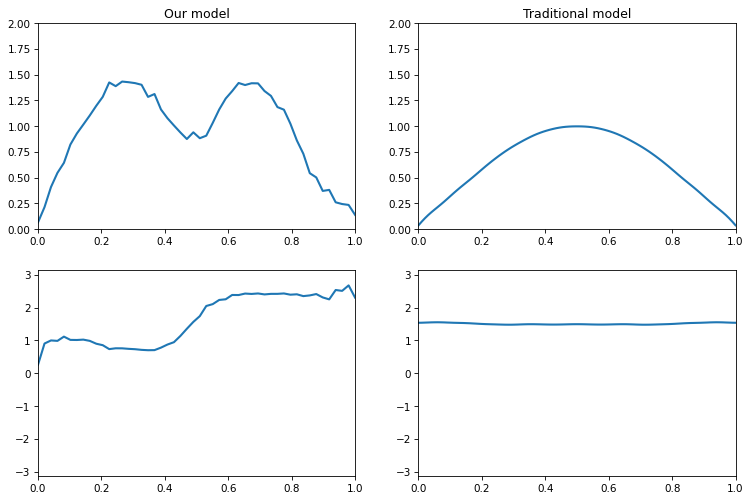

In [195]:
# Particle in a box eigenstate
test_model(lambda x: np.sin(np.pi*x), lambda x: 0*x)